In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)
import warnings; warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from sympy import symbols

import sys; sys.path.append('../')
from PDE_FIND import *

import sys; sys.path.append('../../parametric-discovery/')
from best_subset import *
from frols import frols
from p_linear_regression import PLinearRegression
from r_pca import R_pca
from pde_diff_new import RPCA
from RobustPCA.rpca import RobustPCA

import scipy.io as sio
from scipy.signal import savgol_filter
import itertools

from sklearn.preprocessing import normalize
from sklearn.linear_model import Ridge, BayesianRidge, LinearRegression as SkLinearRegression
from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from abess.linear import LinearRegression
from bess import PdasLm
import pysindy as ps

from tqdm import trange
from os.path import join as join_path
FIGURE_EXPORT_PATH = "/Users/pongpisit/Documents/figure_export/"

Populating the interactive namespace from numpy and matplotlib


In [2]:
def nonzero(wei):
    return tuple(np.nonzero(wei)[0])

def check_percent(bic_scores, complexities):
    slope = (bic_scores[1:]-bic_scores[:-1])/(complexities[1:]-complexities[:-1])
    slope_index = np.argmin(slope)
    percent_improve = 100*np.abs(bic_scores[slope_index+1]-bic_scores[slope_index])/np.abs(bic_scores[slope_index])
    percent_from_1 = 100*np.abs(bic_scores[slope_index+1]-bic_scores[0])/np.abs(bic_scores[0])
    return slope_index+1, percent_improve, percent_from_1

def percent_coeff(pred, ground):
    return 100*(np.abs(pred-ground)/np.abs(ground))

In [3]:
data = sio.loadmat('../Datasets/reaction_diffusion_2d.mat')
u_sol = real(data['usol'])
v_sol = real(data['vsol'])
x = real(data['x'][0])
y = real(data['y'][0])
t = real(data['t'][0])
dt = t[1] - t[0]
dx = x[1] - x[0]
dy = y[1] - y[0]
n = 64
# For WeakPDELibrary
ground_indices_u = (0, 2, 3, 4, 5, 8, 14)
ground_coeff_u = np.array([1.000,-1.000,1.000,-1.000,1.000,0.100,0.100])
ground_indices_v = (1, 2, 3, 4, 5, 9, 15)
ground_coeff_v = np.array([1.000,-1.000,-1.000,-1.000,-1.000,0.100,0.100])

In [4]:
u = np.zeros((n, n, len(t), 2))
u[:, :, :, 0] = u_sol
u[:, :, :, 1] = v_sol

# Odd polynomial terms in (u, v), up to second order derivatives in (u, v)
library_functions = [
    lambda x: x,
    lambda x: x * x * x,
    lambda x, y: x * y * y,
    lambda x, y: x * x * y,
]
library_function_names = [
    lambda x: x,
    lambda x: x + x + x,
    lambda x, y: x + y + y,
    lambda x, y: x + x + y,
]

# Need to define the 2D spatial grid before calling the library
np.random.seed(100)
X, Y, T = np.meshgrid(x, y, t, indexing='ij')
XYT = np.transpose([X, Y, T], [1, 2, 3, 0])

In [5]:
# Need to increase the weak form mesh resolution a bit if data is noisy
weak_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatiotemporal_grid=XYT,
    K=10000,
    is_uniform=True,
    periodic=True,
    include_interaction=True, 
    cache=True
)

# Noiseless
u_noisy = u.copy()
noise_lv = 2
domain_noise = 0.01*np.abs(noise_lv)*np.std(u_noisy)*np.random.randn(u_noisy.shape[0], 
                                                                     u_noisy.shape[1], 
                                                                     u_noisy.shape[2], 
                                                                     u_noisy.shape[3],)
u_noisy = u_noisy + domain_noise

In [6]:
thres_stlsq = None
thres_stlsq = 1e-1
if thres_stlsq is not None:
    optimizer = ps.STLSQ(threshold=thres_stlsq, alpha=1e-5, normalize_columns=True)

# thres = 5e-4
# optimizer = L0BNB(max_nonzeros=12, lam=1e-1, threshold=thres, 
#                   is_normal=False, normalize_columns=True)

In [7]:
model = ps.SINDy(feature_library=weak_lib, optimizer=optimizer, 
                 cache=True, feature_names=['u', 'v'])
model.fit(u_noisy, ensemble=False, library_ensemble=True)
model.print()

(u)' = 0.835 u + 0.172 v + -0.833 uuu + 0.810 vvv + -0.833 uvv + 0.808 uuv + 0.085 u_22 + 0.085 u_11
(v)' = -0.172 u + 0.844 v + -0.811 uuu + -0.842 vvv + -0.810 uvv + -0.842 uuv + 0.086 v_22 + 0.086 v_11


In [8]:
_, ensemble_indices_u = model.validate_coef_list(target_index=0, criterion='bic')[0]
ensemble_indices_u

u_t = (0.048039 +0.000000i)u
    + (1.063809 +0.000000i)v
    + (-0.055041 +0.000000i)uuu
    + (-0.169838 +0.000000i)vvv
    + (-0.055285 +0.000000i)uvv
    + (-0.172918 +0.000000i)uuv
   


(0, 1, 2, 3, 4, 5)

In [9]:
_, ensemble_indices_v = model.validate_coef_list(target_index=1, criterion='bic')[0]
ensemble_indices_v

u_t = (-1.092265 +0.000000i)u
    + (0.025883 +0.000000i)v
    + (0.202145 +0.000000i)uuu
    + (-0.030122 +0.000000i)vvv
    + (0.202818 +0.000000i)uvv
    + (-0.028122 +0.000000i)uuv
   


(0, 1, 2, 3, 4, 5)

In [10]:
stridge_u = set()
stridge_u.add(ensemble_indices_u)
for i in range(len(model.get_coef_list())):
    stridge_u.add(nonzero(model.get_coef_list()[i][0]))
stridge_v = set()
stridge_v.add(ensemble_indices_v)
for i in range(len(model.get_coef_list())):
    stridge_v.add(nonzero(model.get_coef_list()[i][1]))
stridge_u, stridge_v

({(0, 1, 2, 3, 4, 5),
  (0, 1, 2, 3, 4, 5, 8, 14),
  (0,
   1,
   2,
   4,
   8,
   9,
   14,
   15,
   16,
   18,
   20,
   23,
   25,
   27,
   44,
   49,
   52,
   54,
   56,
   59,
   61,
   63),
  (0, 1, 3, 5, 8, 9, 14, 15, 23, 25, 27, 40, 47, 59, 61, 63)},
 {(0, 1, 2, 3, 4, 5),
  (0, 1, 2, 3, 4, 5, 9, 15),
  (0,
   1,
   2,
   4,
   8,
   9,
   14,
   15,
   16,
   18,
   20,
   23,
   25,
   27,
   41,
   43,
   46,
   48,
   50,
   52,
   54,
   56,
   59,
   61,
   63),
  (0, 1, 3, 5, 8, 9, 14, 15)})

In [11]:
X_pre, y_pre = model.feature_library.cached_xp_full[0], model.cached_x_dot

In [12]:
# nonzero(brute_force(X_pre[:, :16], y_pre[:, 0:1], support_size=7))
# nonzero(brute_force(X_pre[:, :16], y_pre[:, 1:2], support_size=7))

In [13]:
max_complexity = 12

In [14]:
target_index = 1
thres = 1e-4
Xbnb = normalize(X_pre, axis=1)
bnb_sols = bnb(Xbnb, y_pre[:, target_index:target_index+1].ravel(), max_nonzeros=max_complexity, 
               lam=1e-1, threshold=thres, normalize=True, corrected_coefficients=True)
bnb_feature_hierarchy = set([tuple(np.nonzero(bnb_sols[:, i:i+1].flatten())[0].tolist()) 
                             for i in range(bnb_sols.shape[1])])
bnb_feature_hierarchy

{(0,),
 (0, 1, 2, 3, 4, 5, 8, 9, 14, 15),
 (0, 2, 4),
 (0, 2, 4, 8, 9, 14, 15),
 (0, 2, 4, 8, 14)}

In [15]:
Xfrols = normalize(X_pre, axis=0)
frols_coeffs,selected_inds_list,_,_,_ = frols(y_pre[:, target_index:target_index+1], Xfrols, max_nonzeros=max_complexity)
selected_inds_list = set(selected_inds_list)
selected_inds_list

{(0,),
 (0, 1, 2, 3, 4, 5, 8, 9, 14, 15, 69, 72),
 (0, 1, 2, 3, 5, 8, 9, 14, 15, 69, 72),
 (0, 1, 3, 5, 8, 9, 14, 15, 69, 72),
 (0, 1, 3, 8, 9, 14, 15, 69, 72),
 (0, 1, 8, 9, 14, 15),
 (0, 1, 8, 9, 14, 15, 69, 72),
 (0, 1, 8, 9, 14, 15, 72),
 (0, 1, 8, 9, 15),
 (0, 1, 9, 15),
 (0, 1, 15),
 (0, 15)}

In [16]:
feature_hierarchy_u = bnb_feature_hierarchy.union(selected_inds_list)
if thres_stlsq is not None:
    if target_index == 0:
        feature_hierarchy_u = stridge_u.union((bnb_feature_hierarchy).union(selected_inds_list))
    elif target_index == 1:
        feature_hierarchy_u = stridge_v.union((bnb_feature_hierarchy).union(selected_inds_list))

In [17]:
br1 = backward_refinement(feature_hierarchy_u, (X_pre,y_pre[:, target_index:target_index+1]), mode='rfe', ic_type='bic', verbose=True)
br2 = backward_refinement(feature_hierarchy_u, (X_pre,y_pre[:, target_index:target_index+1]), mode='k best', ic_type='bic', verbose=True)
br_u=br1+br2; br_u

RFE_PLinearRegression
(0, 2, 4, 8, 9, 14, 15)
(0, 2, 4, 8, 9, 15)
(0, 2, 4, 9, 15)
(0, 2, 4, 15)
(0, 2, 4)
(0, 2)
(0,)
--------------------------------------------------
(0, 1, 3, 8, 9, 14, 15, 69, 72)
(0, 1, 8, 9, 14, 15, 69, 72)
(0, 1, 8, 9, 14, 15, 72)
(0, 1, 8, 9, 14, 15)
(0, 1, 8, 9, 15)
(0, 1, 9, 15)
(0, 1, 15)
(0, 15)
(0,)
--------------------------------------------------
(0, 1, 2, 3, 4, 5)
(0, 1, 2, 3, 4)
(0, 2, 3, 4)
(0, 2, 4)
--------------------------------------------------
(0, 1, 9, 15)
--------------------------------------------------
(0, 1, 8, 9, 15)
--------------------------------------------------
(0, 1, 2, 3, 4, 5, 9, 15)
(1, 2, 3, 4, 5, 9, 15)
(1, 2, 3, 4, 9, 15)
(1, 2, 4, 9, 15)
(1, 2, 4, 15)
(2, 4, 15)
(2, 4)
(2,)
--------------------------------------------------
(0, 1, 2, 3, 5, 8, 9, 14, 15, 69, 72)
(0, 1, 3, 5, 8, 9, 14, 15, 69, 72)
(0, 1, 3, 5, 8, 9, 14, 15, 69)
(0, 1, 3, 5, 8, 9, 14, 15)
(0, 1, 3, 5, 9, 14, 15)
(0, 1, 3, 5, 9, 15)
(0, 1, 3, 9, 15)
(0, 1, 9,

{1: ((0,), -89704.75044145095), 2: ((0, 15), -90094.80085394751), 3: ((0, 1, 15), -90433.5949355086), 4: ((0, 1, 9, 15), -92311.22556061689), 5: ((0, 1, 8, 9, 15), -92462.0683253755), 6: ((0, 1, 3, 5, 9, 15), -94229.07163281288), 7: ((1, 2, 3, 4, 5, 9, 15), -98884.21234254984), 8: ((0, 1, 2, 3, 4, 5, 9, 15), -99223.00785465668), 9: ((0, 1, 2, 3, 4, 5, 9, 14, 15), -99226.63012262661), 10: ((0, 1, 2, 3, 4, 5, 9, 14, 15, 69), -99230.05524578446), 11: ((0, 1, 2, 3, 4, 5, 8, 9, 14, 15, 69), -99224.97738853545), 12: ((0, 1, 2, 3, 4, 5, 8, 9, 14, 15, 69, 72), -99216.5636109259), 13: ((0, 1, 2, 4, 8, 9, 14, 15, 25, 27, 52, 54, 59), -95159.13197962251), 14: ((0, 1, 2, 4, 8, 9, 14, 15, 20, 25, 27, 52, 54, 59), -95187.5852769891), 15: ((0, 1, 2, 4, 8, 9, 14, 15, 16, 18, 20, 27, 46, 59, 61), -95180.41208950873), 16: ((0, 1, 2, 4, 8, 9, 14, 15, 20, 25, 27, 46, 48, 52, 54, 59), -95172.40838968687), 17: ((0, 1, 2, 4, 8, 9, 14, 15, 20, 25, 27, 46, 48, 50, 52, 54, 59), -95191.53572719869), 18: ((0, 1, 

In [18]:
print("Ploting less than max_complexity")
for c in range(max_complexity+1, max(list(br_u.track.keys()))+1):
    del_c = br_u.delete(c)
    if del_c is not None: print(f"Delete {c} complexity")
    else: print(f"{c} not exist")

Ploting less than max_complexity
Delete 13 complexity
Delete 14 complexity
Delete 15 complexity
Delete 16 complexity
Delete 17 complexity
Delete 18 complexity
Delete 19 complexity
Delete 20 complexity
Delete 21 complexity
Delete 22 complexity
Delete 23 complexity
Delete 24 complexity
Delete 25 complexity


In [19]:
# For reproducibility of 2% noise experiment
# u
# (1,) -90432.11492322256
# (1, 14) -90900.56314841735
# (0, 1, 14) -91096.59801155927
# (0, 1, 8, 14) -92631.07213881976
# (0, 1, 8, 14, 15) -92711.06074776711
# (0, 1, 8, 9, 14, 15) -92912.16926463085
# (0, 2, 3, 4, 5, 8, 14) -99273.17863634705
# (0, 1, 2, 3, 4, 5, 8, 14) -99629.82290987358
# (0, 1, 2, 3, 4, 5, 8, 14, 67) -99627.38471701351
# (0, 1, 2, 3, 4, 5, 8, 14, 67, 72) -99626.97018095759
# (0, 1, 2, 3, 4, 5, 8, 9, 14, 67, 72) -99619.72292591527
# (0, 1, 2, 3, 4, 5, 8, 9, 14, 15, 67, 72) -99611.13907227767
# + stlsq before
# (1,) -90432.11492322256
# (1, 14) -90900.56314841735
# (0, 1, 14) -91096.59801155927
# (0, 1, 8, 14) -92631.07213881976
# (0, 1, 8, 14, 15) -92711.06074776711
# (0, 1, 2, 4, 8, 14) -94460.72867681735
# (0, 2, 3, 4, 5, 8, 14) -99273.17863634705
# (0, 1, 2, 3, 4, 5, 8, 14) -99629.82290987358
# (0, 1, 2, 3, 4, 5, 8, 14, 67) -99627.38471701351
# (0, 1, 2, 3, 4, 5, 8, 14, 67, 72) -99626.97018095759
# (0, 1, 2, 3, 4, 5, 8, 9, 14, 67, 72) -99619.72292591527
# (0, 1, 2, 3, 4, 5, 8, 9, 14, 15, 67, 72) -99611.13907227767

# v
# (0,) -89704.75044145095
# (0, 15) -90094.80085394751
# (0, 1, 15) -90433.5949355086
# (0, 1, 9, 15) -92311.22556061689
# (0, 1, 8, 9, 15) -92462.0683253755
# (0, 1, 3, 5, 9, 15) -94229.07163281288
# (1, 2, 3, 4, 5, 9, 15) -98884.21234254984
# (0, 1, 2, 3, 4, 5, 9, 15) -99223.00785465668
# (0, 1, 2, 3, 4, 5, 9, 14, 15) -99226.63012262661
# (0, 1, 2, 3, 4, 5, 9, 14, 15, 69) -99230.05524578446
# (0, 1, 2, 3, 4, 5, 8, 9, 14, 15, 69) -99224.97738853545
# (0, 1, 2, 3, 4, 5, 8, 9, 14, 15, 69, 72) -99216.5636109259
# + stlsq before
# (0,) -89704.75044145095
# (0, 15) -90094.80085394751
# (0, 1, 15) -90433.5949355086
# (0, 1, 9, 15) -92311.22556061689
# (0, 1, 8, 9, 15) -92462.0683253755
# (0, 1, 3, 5, 9, 15) -94229.07163281288
# (1, 2, 3, 4, 5, 9, 15) -98884.21234254984
# (0, 1, 2, 3, 4, 5, 9, 15) -99223.00785465668
# (0, 1, 2, 3, 4, 5, 9, 14, 15) -99226.63012262661
# (0, 1, 2, 3, 4, 5, 9, 14, 15, 69) -99230.05524578446
# (0, 1, 2, 3, 4, 5, 8, 9, 14, 15, 69) -99224.97738853545
# (0, 1, 2, 3, 4, 5, 8, 9, 14, 15, 69, 72) -99216.5636109259

complexities = np.array(sorted(list(br_u.track.keys())))
bic_scores = []
eff_feature_names = []
for com in complexities:
    indices, bic = br_u.track[com]
    bic_scores.append(bic)
    print(indices, bic)
bic_scores = np.array(bic_scores)
min_bic_score = np.min(bic_scores)
div_scale = 1e3
rel_bic_scores = (bic_scores-min_bic_score)/div_scale

(0,) -89704.75044145095
(0, 15) -90094.80085394751
(0, 1, 15) -90433.5949355086
(0, 1, 9, 15) -92311.22556061689
(0, 1, 8, 9, 15) -92462.0683253755
(0, 1, 3, 5, 9, 15) -94229.07163281288
(1, 2, 3, 4, 5, 9, 15) -98884.21234254984
(0, 1, 2, 3, 4, 5, 9, 15) -99223.00785465668
(0, 1, 2, 3, 4, 5, 9, 14, 15) -99226.63012262661
(0, 1, 2, 3, 4, 5, 9, 14, 15, 69) -99230.05524578446
(0, 1, 2, 3, 4, 5, 8, 9, 14, 15, 69) -99224.97738853545
(0, 1, 2, 3, 4, 5, 8, 9, 14, 15, 69, 72) -99216.5636109259


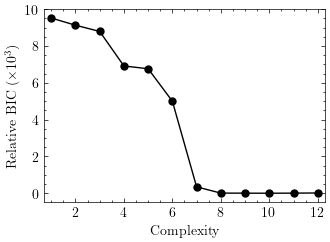

In [20]:
with plt.style.context('science'):
    fig, ax = plt.subplots()
    ax.plot(complexities, rel_bic_scores, color='black', linewidth=2.5//2)
    ax.scatter(complexities, rel_bic_scores, marker='o', c='black', s=25)
    plt.xlim(min(complexities)-0.3,max(complexities)+0.3)
    plt.ylabel(r"Relative BIC ($\times 10^{3}$)")
    plt.xlabel("Complexity")
    plt.tight_layout()
    plt.show()

In [21]:
optimal_slope_index, im1, im2 = check_percent(bic_scores, complexities)
optimal_slope_index, im1, im2

(6, 4.940238324619058, 10.232971894939059)

In [22]:
if target_index == 0: ground = ground_coeff_u
elif target_index ==1 : ground = ground_coeff_v
pred = np.linalg.lstsq(X_pre[:, br_u.track[optimal_slope_index+1][0]], 
                       y_pre[:, target_index:target_index+1], rcond=None)[0].flatten()
errs = percent_coeff(pred, ground)
errs.mean(), errs.std()

(3.0919189084692356, 2.043739558282274)

In [23]:
metric_dict = {'rel_bic_scores': rel_bic_scores, 
               'complexities': complexities, 
               'min_bic_score': min_bic_score, 
               'found_coeff': pred, 
               'percent_coefficient_error_mean': errs.mean(), 
               'percent_coefficient_error_std': errs.std()}
metric_dict

{'rel_bic_scores': array([9.52530480e+00, 9.13525439e+00, 8.79646031e+00, 6.91882969e+00,
        6.76798692e+00, 5.00098361e+00, 3.45842903e-01, 7.04739113e-03,
        3.42512316e-03, 0.00000000e+00, 5.07785725e-03, 1.34916349e-02]),
 'complexities': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 'min_bic_score': -99230.05524578446,
 'found_coeff': array([ 0.95159089, -0.99962214, -0.9485541 , -0.99847544, -0.94917896,
         0.09689751,  0.09671691]),
 'percent_coefficient_error_mean': 3.0919189084692356,
 'percent_coefficient_error_std': 2.043739558282274}

In [24]:
# target_index2name = ['u', 'v']
# file_name = f"./Visualization/reaction_diffustion_2d_{target_index2name[target_index]}_bnb_frols_noise_lv{noise_lv}.mat"
# print(file_name)
# sio.savemat(file_name, metric_dict)

In [25]:
target_index2name = ['u', 'v']
file_name = f"./Visualization/reaction_diffustion_2d_{target_index2name[target_index]}_stlsq_bnb_frols_noise_lv{noise_lv}.mat"
print(file_name)
sio.savemat(file_name, metric_dict)

./Visualization/reaction_diffustion_2d_v_stlsq_bnb_frols_noise_lv2.mat


In [26]:
all_possible_candidates = sorted(set().union(*[br_u.track[mc][0] for mc in br_u.track.keys()]))
out = np.hstack([brute_force(X_pre[:, all_possible_candidates], y_pre[:, target_index:target_index+1], 
                             support_size=i+1) for i in range(len(all_possible_candidates))]).T
for i in range(len(out)):
    print(tuple(np.array(all_possible_candidates)[list(nonzero(out[i]))]))

(0,)
(0, 15)
(0, 1, 15)
(0, 1, 9, 15)
(0, 1, 8, 9, 15)
(0, 1, 3, 5, 9, 15)
(1, 2, 3, 4, 5, 9, 15)
(0, 1, 2, 3, 4, 5, 9, 15)
(0, 1, 2, 3, 4, 5, 9, 14, 15)
(0, 1, 2, 3, 4, 5, 9, 14, 15, 69)
(0, 1, 2, 3, 4, 5, 8, 9, 14, 15, 69)
(0, 1, 2, 3, 4, 5, 8, 9, 14, 15, 69, 72)


In [27]:
feature_hierarchy = set(tuple(np.array(all_possible_candidates)[list(nonzero(out[i]))]) for i in range(len(out)))

In [28]:
br1 = backward_refinement(feature_hierarchy, (X_pre,y_pre[:, target_index:target_index+1]), mode='rfe', ic_type='bic', verbose=True)
br2 = backward_refinement(feature_hierarchy, (X_pre,y_pre[:, target_index:target_index+1]), mode='k best', ic_type='bic', verbose=True)
br=br1+br2; br

RFE_PLinearRegression
(1, 2, 3, 4, 5, 9, 15)
(1, 2, 3, 4, 9, 15)
(1, 2, 4, 9, 15)
(1, 2, 4, 15)
(2, 4, 15)
(2, 4)
(2,)
--------------------------------------------------
(0, 15)
(0,)
--------------------------------------------------
(0, 1, 2, 3, 4, 5, 9, 14, 15)
(0, 1, 2, 3, 4, 5, 9, 15)
(1, 2, 3, 4, 5, 9, 15)
--------------------------------------------------
(0, 1, 3, 5, 9, 15)
(0, 1, 3, 9, 15)
(0, 1, 9, 15)
(0, 1, 15)
(0, 15)
--------------------------------------------------
(0, 1, 15)
--------------------------------------------------
(0, 1, 9, 15)
--------------------------------------------------
(0, 1, 2, 3, 4, 5, 8, 9, 14, 15, 69)
(0, 1, 2, 3, 4, 5, 9, 14, 15, 69)
(0, 1, 2, 3, 4, 5, 9, 14, 15)
--------------------------------------------------
(0, 1, 8, 9, 15)
(0, 1, 9, 15)
--------------------------------------------------
(0, 1, 2, 3, 4, 5, 9, 15)
--------------------------------------------------
(0, 1, 2, 3, 4, 5, 8, 9, 14, 15, 69, 72)
(0, 1, 2, 3, 4, 5, 8, 9, 14, 15, 69)

{1: ((0,), -89704.75044145095), 2: ((0, 15), -90094.80085394751), 3: ((0, 1, 15), -90433.5949355086), 4: ((0, 1, 9, 15), -92311.22556061689), 5: ((0, 1, 8, 9, 15), -92462.0683253755), 6: ((0, 1, 3, 5, 9, 15), -94229.07163281288), 7: ((1, 2, 3, 4, 5, 9, 15), -98884.21234254984), 8: ((0, 1, 2, 3, 4, 5, 9, 15), -99223.00785465668), 9: ((0, 1, 2, 3, 4, 5, 9, 14, 15), -99226.63012262661), 10: ((0, 1, 2, 3, 4, 5, 9, 14, 15, 69), -99230.05524578446), 11: ((0, 1, 2, 3, 4, 5, 8, 9, 14, 15, 69), -99224.97738853545), 12: ((0, 1, 2, 3, 4, 5, 8, 9, 14, 15, 69, 72), -99216.5636109259)}

In [29]:
print("Ploting less than max_complexity")
for c in range(max_complexity+1, max(list(br.track.keys()))+1):
    del_c = br.delete(c)
    if del_c is not None: print(f"Delete {c} complexity")
    else: print(f"{c} not exist")

Ploting less than max_complexity


In [30]:
# For reproducibility of 2% noise experiment
# u
# (1,) -90432.11492322256
# (1, 14) -90900.56314841735
# (0, 1, 14) -91096.59801155927
# (0, 1, 8, 14) -92631.07213881976
# (0, 1, 8, 14, 15) -92711.06074776711
# (0, 1, 2, 4, 8, 14) -94460.72867681735
# (0, 2, 3, 4, 5, 8, 14) -99273.17863634705
# (0, 1, 2, 3, 4, 5, 8, 14) -99629.82290987358
# (0, 1, 2, 3, 4, 5, 8, 14, 67) -99627.38471701351
# (0, 1, 2, 3, 4, 5, 8, 14, 67, 72) -99626.97018095759
# (0, 1, 2, 3, 4, 5, 8, 9, 14, 67, 72) -99619.72292591527
# (0, 1, 2, 3, 4, 5, 8, 9, 14, 15, 67, 72) -99611.13907227767
# + stlsq before
# (1,) -90432.11492322256
# (1, 14) -90900.56314841735
# (0, 1, 14) -91096.59801155927
# (0, 1, 8, 14) -92631.07213881976
# (0, 1, 8, 14, 15) -92711.06074776711
# (0, 1, 2, 4, 8, 14) -94460.72867681735
# (0, 2, 3, 4, 5, 8, 14) -99273.17863634705
# (0, 1, 2, 3, 4, 5, 8, 14) -99629.82290987358
# (0, 1, 2, 3, 4, 5, 8, 14, 67) -99627.38471701351
# (0, 1, 2, 3, 4, 5, 8, 14, 67, 72) -99626.97018095759
# (0, 1, 2, 3, 4, 5, 8, 9, 14, 67, 72) -99619.72292591527
# (0, 1, 2, 3, 4, 5, 8, 9, 14, 15, 67, 72) -99611.13907227767

# v
# (0,) -89704.75044145095
# (0, 15) -90094.80085394751
# (0, 1, 15) -90433.5949355086
# (0, 1, 9, 15) -92311.22556061689
# (0, 1, 8, 9, 15) -92462.0683253755
# (0, 1, 3, 5, 9, 15) -94229.07163281288
# (1, 2, 3, 4, 5, 9, 15) -98884.21234254984
# (0, 1, 2, 3, 4, 5, 9, 15) -99223.00785465668
# (0, 1, 2, 3, 4, 5, 9, 14, 15) -99226.63012262661
# (0, 1, 2, 3, 4, 5, 9, 14, 15, 69) -99230.05524578446
# (0, 1, 2, 3, 4, 5, 8, 9, 14, 15, 69) -99224.97738853545
# (0, 1, 2, 3, 4, 5, 8, 9, 14, 15, 69, 72) -99216.5636109259
# + stlsq before
# (0,) -89704.75044145095
# (0, 15) -90094.80085394751
# (0, 1, 15) -90433.5949355086
# (0, 1, 9, 15) -92311.22556061689
# (0, 1, 8, 9, 15) -92462.0683253755
# (0, 1, 3, 5, 9, 15) -94229.07163281288
# (1, 2, 3, 4, 5, 9, 15) -98884.21234254984
# (0, 1, 2, 3, 4, 5, 9, 15) -99223.00785465668
# (0, 1, 2, 3, 4, 5, 9, 14, 15) -99226.63012262661
# (0, 1, 2, 3, 4, 5, 9, 14, 15, 69) -99230.05524578446
# (0, 1, 2, 3, 4, 5, 8, 9, 14, 15, 69) -99224.97738853545
# (0, 1, 2, 3, 4, 5, 8, 9, 14, 15, 69, 72) -99216.5636109259

complexities = np.array(sorted(list(br.track.keys())))
bic_scores = []
eff_feature_names = []
for com in complexities:
    indices, bic = br.track[com]
    bic_scores.append(bic)
    print(indices, bic)
bic_scores = np.array(bic_scores)
min_bic_score = np.min(bic_scores)
div_scale = 1e3
rel_bic_scores = (bic_scores-min_bic_score)/div_scale

(0,) -89704.75044145095
(0, 15) -90094.80085394751
(0, 1, 15) -90433.5949355086
(0, 1, 9, 15) -92311.22556061689
(0, 1, 8, 9, 15) -92462.0683253755
(0, 1, 3, 5, 9, 15) -94229.07163281288
(1, 2, 3, 4, 5, 9, 15) -98884.21234254984
(0, 1, 2, 3, 4, 5, 9, 15) -99223.00785465668
(0, 1, 2, 3, 4, 5, 9, 14, 15) -99226.63012262661
(0, 1, 2, 3, 4, 5, 9, 14, 15, 69) -99230.05524578446
(0, 1, 2, 3, 4, 5, 8, 9, 14, 15, 69) -99224.97738853545
(0, 1, 2, 3, 4, 5, 8, 9, 14, 15, 69, 72) -99216.5636109259


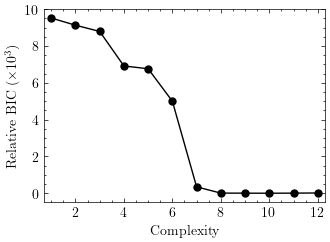

In [31]:
with plt.style.context('science'):
    fig, ax = plt.subplots()
    ax.plot(complexities, rel_bic_scores, color='black', linewidth=2.5//2)
    ax.scatter(complexities, rel_bic_scores, marker='o', c='black', s=25)
    plt.xlim(min(complexities)-0.3,max(complexities)+0.3)
    plt.ylabel(r"Relative BIC ($\times 10^{3}$)")
    plt.xlabel("Complexity")
    plt.tight_layout()
    plt.show()

In [32]:
check_percent(bic_scores, complexities)

(6, 4.940238324619058, 10.232971894939059)

In [33]:
metric_dict = {'rel_bic_scores': rel_bic_scores, 
               'complexities': complexities, 
               'min_bic_score': min_bic_score, 
               'found_coeff': pred, 
               'percent_coefficient_error_mean': errs.mean(), 
               'percent_coefficient_error_std': errs.std()}
metric_dict

{'rel_bic_scores': array([9.52530480e+00, 9.13525439e+00, 8.79646031e+00, 6.91882969e+00,
        6.76798692e+00, 5.00098361e+00, 3.45842903e-01, 7.04739113e-03,
        3.42512316e-03, 0.00000000e+00, 5.07785725e-03, 1.34916349e-02]),
 'complexities': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 'min_bic_score': -99230.05524578446,
 'found_coeff': array([ 0.95159089, -0.99962214, -0.9485541 , -0.99847544, -0.94917896,
         0.09689751,  0.09671691]),
 'percent_coefficient_error_mean': 3.0919189084692356,
 'percent_coefficient_error_std': 2.043739558282274}

In [34]:
# target_index2name = ['u', 'v']
# file_name = f"./Visualization/reaction_diffustion_2d_{target_index2name[target_index]}_bnb_frols_bruteforce_noise_lv{noise_lv}.mat"
# print(file_name)
# sio.savemat(file_name, metric_dict)

In [35]:
target_index2name = ['u', 'v']
file_name = f"./Visualization/reaction_diffustion_2d_{target_index2name[target_index]}_stlsq_bnb_frols_bruteforce_noise_lv{noise_lv}.mat"
print(file_name)
sio.savemat(file_name, metric_dict)

./Visualization/reaction_diffustion_2d_v_stlsq_bnb_frols_bruteforce_noise_lv2.mat
